In [38]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
sns.set() 

import pandas as pd
import numpy as np
from scipy import stats as st

import warnings
warnings.filterwarnings('ignore')

import sys, os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from utils import *
from data_generating_funcs import *
sns.set(style="ticks", font_scale=1.2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def generate_WV(beta, m, V='random', sigma=0.1):
    p = len(beta)
    W = np.zeros((m, p))
    for j, b in enumerate(beta):
        W[:, j] = np.random.normal(b, sigma, size=m)
        # W[:, j] = b
    W = torch.tensor(W, dtype=torch.float32)
    if V=='random':
        V = torch.tensor(np.random.normal(size=(1, m)), dtype=torch.float32)
    elif V == 'sequential':
        V = torch.tensor((np.arange(m)+1)/m, dtype=torch.float32)
    return W, V

def generate_2lnn_data(W, V, n, corr=0.5):
    p = W.shape[1]
    sigma = np.eye(p)
    sigma[0, 1] = corr
    sigma[1, 0] = corr
    X = np.random.multivariate_normal(np.zeros(p), sigma, size=n)
    X = torch.tensor(X, dtype=torch.float32)
    Y = torch.tensor(torch.matmul(V, torch.relu(torch.matmul(W, X.T))).detach().numpy(),
                     dtype=torch.float32)
    return X, Y.reshape(-1, 1)

In [ ]:
beta = [5,4,3,2,1] + list(np.zeros(95))

#beta = [1.5, 1.2, 1, 0, 0, 0]  #+ list(np.zeros(900))

big_df = pd.DataFrame()
W,V=generate_WV(beta, 12, V='random', sigma=0.1)
for t in range(10):
    X,y=generate_2lnn_data(W,V,n=1000,corr=0.5)
    df = vi_experiment_wrapper(X, y, 50, exp_iter=t, ix=[0], lambda_path=np.logspace(1,2,3), 
                              include_linear=True, early_stop=False, max_epochs=20, include_rf=True)
    big_df = big_df.append(df)
        
#big_df.to_csv("../results/highd.csv", index=False)

In [65]:
omg = pd.merge(big_df[big_df.method!='retrain'][['iter', 'method', 'vi', 'time']],
         big_df[big_df.method=='retrain'][['iter', 'vi', 'time']],
         on='iter', suffixes=['','_retrain'])
omg['error'] = (omg.vi_retrain - omg.vi)/omg.vi_retrain
omg = omg[omg.method != 'full model']

In [68]:
omg['Method'] = omg.method.apply(lambda x: x.title())

omg.loc[omg.method.isin(['ols', 'rf']), 'Method'] = omg[omg.method.isin(['ols', 'rf'])].method.apply(lambda x: x.upper())
omg.loc[omg.method=='lazy', 'Method'] = 'LazyVI'
omg = omg.append( big_df[big_df.method=='retrain'][['method', 'iter', 'vi', 'time']])
omg['Error'] = omg.error.fillna(0)
omg.loc[omg.method=='retrain', 'Method'] = 'Retrain'
omg['Time'] = omg.time

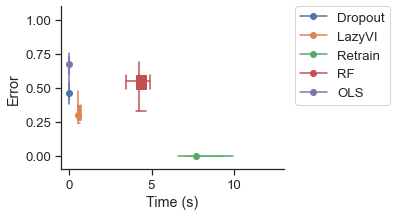

In [77]:
fig,ax = plt.subplots(figsize=(4,3))
plt.ylim(-.1, 1.1)
plt.xlim(-.5, 13)
plt.xlabel('Time (s)')
plt.ylabel('Error')
#plt.ylabel('Error')
colors = ['b', 'orange', 'g']

for i, method in enumerate(['Dropout', 'LazyVI', 'Retrain', 'RF', 'OLS']):

    d = omg[omg.Method==method]
    boxplot_2d(d.Time, d.Error, ax=ax, co=sns.color_palette()[i], method=method)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # Hide the right and top spines

    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    #ax.axes.yaxis.set_ticks([])
    #plt.title(var_groups[k])

plt.savefig("../results/images/highd_curvey.pdf", format='pdf', bbox_inches = "tight")